In [1]:
#=pkgs = [
	"CategoricalArrays","Chain","Conda","CSV","DataFrames","Dates",
	"FileIO","HTTP","ImageShow","LaTeXStrings","Metrics","Plots",
	"Plotly","PrettyTables","PyCall","Statistics","StatsBase",
	"StatsPlots","StateSpaceModels","XLSX"
	];
expr = "using " * join(pkgs, ", ")
eval(Meta.parse(expr))=#

In [2]:
#=using PlutoUI; PlutoUI.TableOfContents(
    title = "Pronóstico de Inflación por Componentes", 
    depth = 5)=#
#using CategoricalArrays,Chain,Conda,CSV,DataFrames,Dates,FileIO,HTTP
#using ImageShow,LaTeXStrings,Metrics,Plots,Plotly,PrettyTables,PyCall
#using Statistics,StatsBase,StatsPlots,StateSpaceModels,XLSX;
using CSV,DataFrames,Dates,FileIO,GLM,Plots,PrettyTables,PyCall
# Pkg.add(PackageSpec(name="PyCall", rev="master"))
# Pkg.build("PyCall")

# within a Julia REPL
# using Conda
# Conda.pip_interop(true)
# Conda.pip("install", "webio_jupyter_extension")

wd = @__DIR__

#get_grouped_indices()
include(wd * "/Functions/update_data.jl");  # Obtener información
include(wd * "/Functions/plot_type.jl");   # Gráficos dinámicos o estáticos
include(wd * "/Functions/apply_models.jl");   # Modelos	

\pagebreak

# Resumen Ejecutivo

En este documento se expone un proceso en Julia para calcular variaciones mensuales e interanuales (y la contribución de los componentes a dichas variaciones) a partir de los componentes del Indice de Precios al Consumidor (IPC). En el mismo se obtiene lo siguiente, por cada agrupación y sus componentes:

- Índice;
- Tasa de crecimiento mensual (pendiente);
- Tasa de crecimiento interanual (pendiente);
- Contribución a la tasa de crecimiento mensual (pendiente); y
- Contribución a la tasa de crecimiento interanual (pendiente).

El procedimiento se realiza mediante funciones programadas, por lo que los cálculos a partir de los grupos se realizan automáticamente, tomando en cuenta el número de grupos que se necesite crear; la automatización implica la eliminación de errores que puedan generarse al usar fórmulas en Excel.

\pagebreak

# Datos Iniciales

## Página Web, grupos


In [3]:
# Conda.pip("install", "openpyxl")
#import Conda
#Conda.add("openpyxl")
#using PyCall
#PyCall.@pyimport openpyxl
pd = PyCall.pyimport("pandas");

In [4]:
# Read Excel data
url = "https://www.bch.hn/estadisticos/GIE/LIBSERIE%20IPC%20RUBROS/Serie%20Mensual%20y%20Promedio%20Anual%20del%20%C3%8Dndice%20de%20Precios%20al%20Consumidor%20por%20Rubros.xlsx"
df_cpi_grupos = pd.read_excel(url)

# Drop columns and rows with missing values
df_cpi_grupos = df_cpi_grupos.dropna(axis=1, thresh=3)
df_cpi_grupos = df_cpi_grupos.dropna(axis=0, thresh=3)
df_cpi_grupos = df_cpi_grupos.dropna(axis=1)

# Drop first row (name of variables in Spanish)
df_cpi_grupos = df_cpi_grupos.drop(df_cpi_grupos.index[0])

# Rename columns
df_cpi_grupos.columns = [
    "Fechas",
    "Alimentos y Bebidas no Alcohólicas",
    "Bebidas Alcohólicas y Tabaco",
    "Prendas de Vestir y Calzado",
    "Alojamiento, Agua, Electricidad, Gas y Otros Combustibles",
    "Muebles y Artículos para la Conservación del Hogar",
    "Salud",
    "Transporte",
    "Comunicaciones",
    "Recreación y Cultura",
    "Educación",
    "Restaurantes y Hoteles",
    "Cuidado Personal",
    "IPC"]

# To DataFrame
df_cpi_grupos = DataFrames.DataFrame([col => Base.collect(df_cpi_grupos[col]) for col in df_cpi_grupos.columns])
df_cpi_grupos = df_cpi_grupos[2:end,:]

# Drop rows containing "PROMEDIO"
df_cpi_grupos = DataFrames.filter(
	row -> row.Fechas != "PROMEDIO", df_cpi_grupos)

# # Add months as date
df_cpi_grupos.Fechas = Base.collect(
	Dates.Date(1991,1,1):Dates.Month(1):Dates.Date(1991,1,1)+Dates.Month(size(df_cpi_grupos)[1]-1))

# Guardar en archivo y leer en formato correcto
CSV.write(
	wd * "/Data/Base/data_rubros_web.csv", 
	delim = ';',
	df_cpi_grupos);
df_cpi_grupos = CSV.read(
	#dir * "./Data/Base/data.csv",
	wd * "/Data/Base/data_rubros_web.csv", 
	DataFrames.DataFrame);

En este informe se presenta el gráfico del primer componente del grupo, sin embargo, puede obtenerse un gráfico por cada componente y del IPC general^[j=13 en el código.].


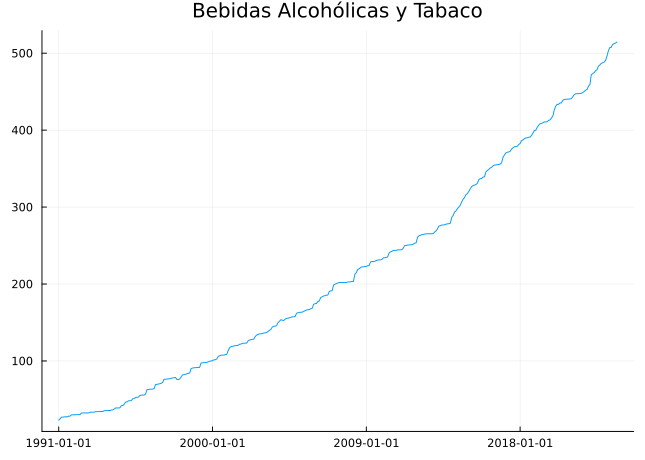

In [5]:
tipo = "line";
grupos2 = DataFrames.DataFrame(
	No = 1:Base.size(df_cpi_grupos, 2)-1,
	Nombre = DataFrames.names(df_cpi_grupos)[2:end]);
nombrar = Base.Array(grupos2.Nombre);
nombrar = string.(nombrar);
j = 2#size(nombrar)[1] # 1:13

#dynamic_plot(df, nombrar[i], tipo)
# static_plot(df_cpi_grupos, nombrar[j], tipo)
df, col_name, plot_type = df_cpi_grupos, nombrar[j], tipo
col_name = Symbol(col_name)
plot_type = Symbol(plot_type)
fig_001 = Plots.plot(
    df.Fechas, 
    df[:, col_name],
    legend = false,
    label = String(col_name),
    title = String(col_name),)
#=Plots.savefig(
	fig_001,
	wd * "/Figuras/fig_001.png")
FileIO.load(wd * "/Figuras/fig_001.png")=#

Los pesos de cada rubro pueden aproximarse mediante una regresión lineal:


In [6]:
data = copy(df_cpi_grupos[:,2:end])
xnames = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","Y"]
DataFrames.rename!(data, Base.names(data) .=> xnames);
reg = GLM.lm(GLM.@formula(Y ~  0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12),data)
w = coef(reg)
data[:,:IPC_estim] = data[:,end]
data[!,:IPC_estim] = 
	data.x1 .* w[1] + data.x2 .* w[2] + data.x3 .* w[3] + 
	data.x4 .* w[4] + data.x5 .* w[5] + data.x6 .* w[6] +
	data.x7 .* w[7] + data.x8 .* w[8] + data.x9 .* w[9] + 
	data.x10 .* w[10] + data.x11 .* w[11] + data.x12 .* w[12]
DataFrames.rename!(
	data, 
	Base.names(data) .=> 
	vcat(Base.names(df_cpi_grupos)[2:end],"IPC_Estim"));
data = hcat(df_cpi_grupos[:,1],data)
DataFrames.rename!(
	data, 
	Base.names(data)[1] .=> 
	"Fechas");
formato_tabla(data[end-20:end,1:6])
formato_tabla(data[end-20:end,7:end])

 ------------ ------------------------------------ ------------------------------ ----------------------------- ----------------------------------------------------------- ----------------------------------------------------
      Fechas   Alimentos y Bebidas no Alcohólicas   Bebidas Alcohólicas y Tabaco   Prendas de Vestir y Calzado   Alojamiento, Agua, Electricidad, Gas y Otros Combustibles   Muebles y Artículos para la Conservación del Hogar 
        Date                              Float64                        Float64                       Float64                                                     Float64                                              Float64 
 ------------ ------------------------------------ ------------------------------ ----------------------------- ----------------------------------------------------------- ----------------------------------------------------
  2022-01-01                             317.5000                       457.2000                    

## Página Web, Regiones


In [7]:
url = "https://www.bch.hn/estadisticos/GIE/LIBSerie%20IPC%20Region/Serie%20Mensual%20y%20Promedio%20Anual%20del%20%C3%8Dndice%20de%20Precios%20al%20Consumidor%20por%20Regi%C3%B3n.xlsx"

# Read Excel data
df_cpi_regiones = pd.read_excel(url)

# Drop columns and rows with missing values
df_cpi_regiones = df_cpi_regiones.dropna(axis=1, thresh=3)
df_cpi_regiones = df_cpi_regiones.dropna(axis=0, thresh=3)
df_cpi_regiones = df_cpi_regiones.dropna(axis=1)

# Drop first row (name of variables in Spanish)
df_cpi_regiones = df_cpi_regiones.drop(df_cpi_regiones.index[0])

# Rename columns
df_cpi_regiones.columns = [
    "Fechas",
    "Central_Metropolitana",
    "Resto_Central",
    "Norte_Metropolitana",
    "Resto_Norte",
    "Sur",
    "Oriental",
    "Occidental",
    "IPC"];

# # To DataFrame
df_cpi_regiones = DataFrames.DataFrame([col => Base.collect(df_cpi_regiones[col]) for col in df_cpi_regiones.columns])
df_cpi_regiones = df_cpi_regiones[2:end,:]

# # Drop rows containing "PROMEDIO"
df_cpi_regiones = DataFrames.filter(
	row -> row.Fechas != "PROMEDIO", df_cpi_regiones)

# # Add months as date
df_cpi_regiones.Fechas = Base.collect(Dates.Date(1991,1,1):Dates.Month(1):Dates.Date(1991,1,1)+Dates.Month(size(df_cpi_regiones)[1]-1))
# df_cpi_regiones = df_cpi_regiones[:,vcat(size(df_cpi_regiones)[2],collect(2:size(df_cpi_regiones)[2]-1))]

# Guardar en archivo y leer en formato correcto
CSV.write(
	wd * "/Data/Base/data_regiones_web.csv", 
	delim = ';',
	df_cpi_regiones);
df_cpi_regiones = CSV.read(
	#dir * "./Data/Base/data.csv",
	wd * "/Data/Base/data_regiones_web.csv", 
	DataFrames.DataFrame);

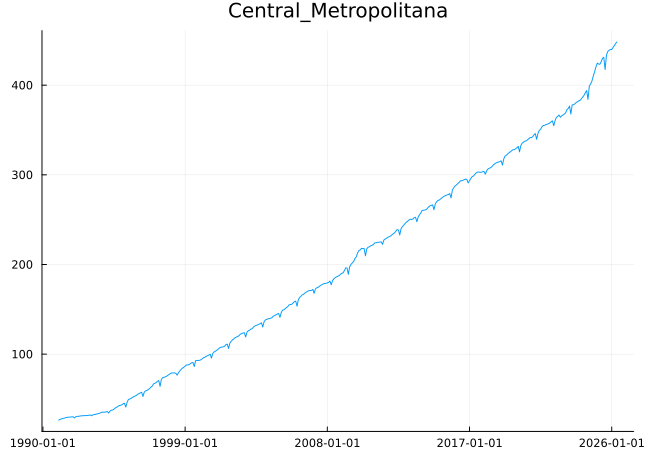

In [8]:
tipo = "line";
grupos2 = DataFrames.DataFrame(
	No = 1:Base.size(df_cpi_regiones, 2)-1,
	Nombre = DataFrames.names(df_cpi_regiones)[2:end]);
nombrar = Base.Array(grupos2.Nombre);
nombrar = string.(nombrar);
j = 1#size(nombrar)[1] # 1:8

#dynamic_plot(df, nombrar[i], tipo)
# static_plot(df_cpi_grupos, nombrar[j], tipo)
df, col_name, plot_type = df_cpi_regiones, nombrar[j], tipo
col_name = Symbol(col_name)
plot_type = Symbol(plot_type)
fig_002 = Plots.plot(
    df.Fechas, 
    df[:, col_name],
    legend = false,
    label = String(col_name),
    title = String(col_name),)
#=Plots.savefig(
	fig_002,
	wd * "/Figuras/fig_002.png")
FileIO.load(wd * "/Figuras/fig_002.png")=#

También puede aplicarse una regresión lineal para estimar los pesos por región:


In [9]:
data = copy(df_cpi_regiones[:,2:end])
reg = GLM.lm(GLM.@formula(IPC ~  0 + Central_Metropolitana + Resto_Central + Norte_Metropolitana + Resto_Norte + Sur + Oriental + Occidental),data)
w = coef(reg)
data[:,:IPC_estim] = data[:,end]
data[!,:IPC_estim] = 
	data.Central_Metropolitana .* w[1] + data.Resto_Central .* w[2] + data.Norte_Metropolitana .* w[3] + 
	data.Resto_Norte .* w[4] + data.Sur .* w[5] + data.Oriental .* w[6] +
	data.Occidental .* w[7]
data = hcat(df_cpi_regiones[:,1],data)
DataFrames.rename!(
	data, 
	Base.names(data)[1] .=> 
	"Fechas");
formato_tabla(data[end-20:end,:])

 ------------ ----------------------- --------------- --------------------- ------------- ---------- ---------- ------------ ---------- -----------
      Fechas   Central_Metropolitana   Resto_Central   Norte_Metropolitana   Resto_Norte        Sur   Oriental   Occidental        IPC   IPC_estim 
        Date                 Float64         Float64               Float64       Float64    Float64    Float64      Float64    Float64     Float64 
 ------------ ----------------------- --------------- --------------------- ------------- ---------- ---------- ------------ ---------- -----------
  2024-09-01                401.5000        361.3000              368.6000      342.6000   373.1000   366.2000     358.9000   374.3000    374.2627
  2024-10-01                404.6000        368.4000              371.7000      346.6000   376.0000   370.6000     360.9000   377.8000    377.8028
  2024-11-01                410.3000        377.1000              379.8000      351.5000   381.9000   375.9000    